# ICAT3260 Machine Learning for Computer Vision
## Exercise Set 8 (4.11.2025)

**Goal:** Combine feature detection (Ex6), homogeneous coordinates (Ex7), and image transforms (Theme 8) for image stitching.


### 1) Translation with Homogeneous Coordinates
**Task:** Calculate the 3x3 translation matrix $T_1$ to move point $(10, 20)$ to $(30, 25)$.

**Solution:**
Translation vector: $\Delta x = 30-10=20$, $\Delta y = 25-20=5$.


In [1]:
import numpy as np

# Original point
p1 = np.array([10, 20, 1])

# Desired point (30, 25) -> Translation d = (20, 5)
tx, ty = 20, 5

T1 = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])

print("T1 (Translation Matrix):\n", T1)
print("Verified Translation:", T1 @ p1)


T1 (Translation Matrix):
 [[ 1  0 20]
 [ 0  1  5]
 [ 0  0  1]]
Verified Translation: [30 25  1]


### 2) Rotation with Homogeneous Coordinates
**Task:** Calculate the 3x3 rotation matrix $T_2$ to rotate point $(10, 20)$ by 30 degrees clockwise.

**Solution:**
Clockwise rotation by angle $\theta$ corresponds to rotating by $-\theta$ in standard mathematical convention (counter-clockwise is positive).
Angle: $\theta = -30^{\circ}$ ($30^{\circ}$ clockwise).


In [2]:
# Cos(-30) = Cos(30), Sin(-30) = -Sin(30)
theta_deg = -30
theta = np.deg2rad(theta_deg)

c, s = np.cos(theta), np.sin(theta)

T2 = np.array([
    [c, -s, 0],
    [s,  c, 0],
    [0,  0, 1]
])

print(f"T2 (Rotation Matrix for {theta_deg} deg):\n", T2)


T2 (Rotation Matrix for -30 deg):
 [[ 0.8660254  0.5        0.       ]
 [-0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]


### 3) Composition of Transformations
**Task:** Compose $T_1$ and $T_2$ and calculate coordinates for $(10, 20)$.
*Note:* The order isn't explicitly defined, but transformation usually implies applying one then the other. If we interpret 'compose matrices T1 and T2' we usually do $T_{composed} = T_2 \cdot T_1$ (Translate then Rotate) or $T_1 \cdot T_2$ (Rotate then Translate). Let's assume Rotate then Translate ($T_1 \cdot T_2$) is a common operation (rotate object then move it), or standard composition. Let's calculate $T_{final} = T_1 @ T_2$.


In [3]:
# Order: Rotate first, then Translate usually (T1 @ T2)
# p_new = T1 * (T2 * p)
T_composed = T1 @ T2

print("Composed Matrix (T1 @ T2):\n", T_composed)

p_original = np.array([10, 20, 1])
p_final = T_composed @ p_original

# Normalize (though w should be 1)
p_final_coords = p_final[:2] / p_final[2]

print(f"Original: {p_original[:2]}")
print(f"Transformed: {p_final_coords}")


Composed Matrix (T1 @ T2):
 [[ 0.8660254  0.5       20.       ]
 [-0.5        0.8660254  5.       ]
 [ 0.         0.         1.       ]]
Original: [10 20]
Transformed: [38.66025404 17.32050808]


### 4) SIFT Matching & Homography with RANSAC
**Task:** Use SIFT to find features between two images and RANSAC to filter matches.
**Setup:** Ensure `left.png` and `right.png` are in the directory.


RANSAC Threshold: 5.0
Original Matches: 73
Inlier Matches: 69


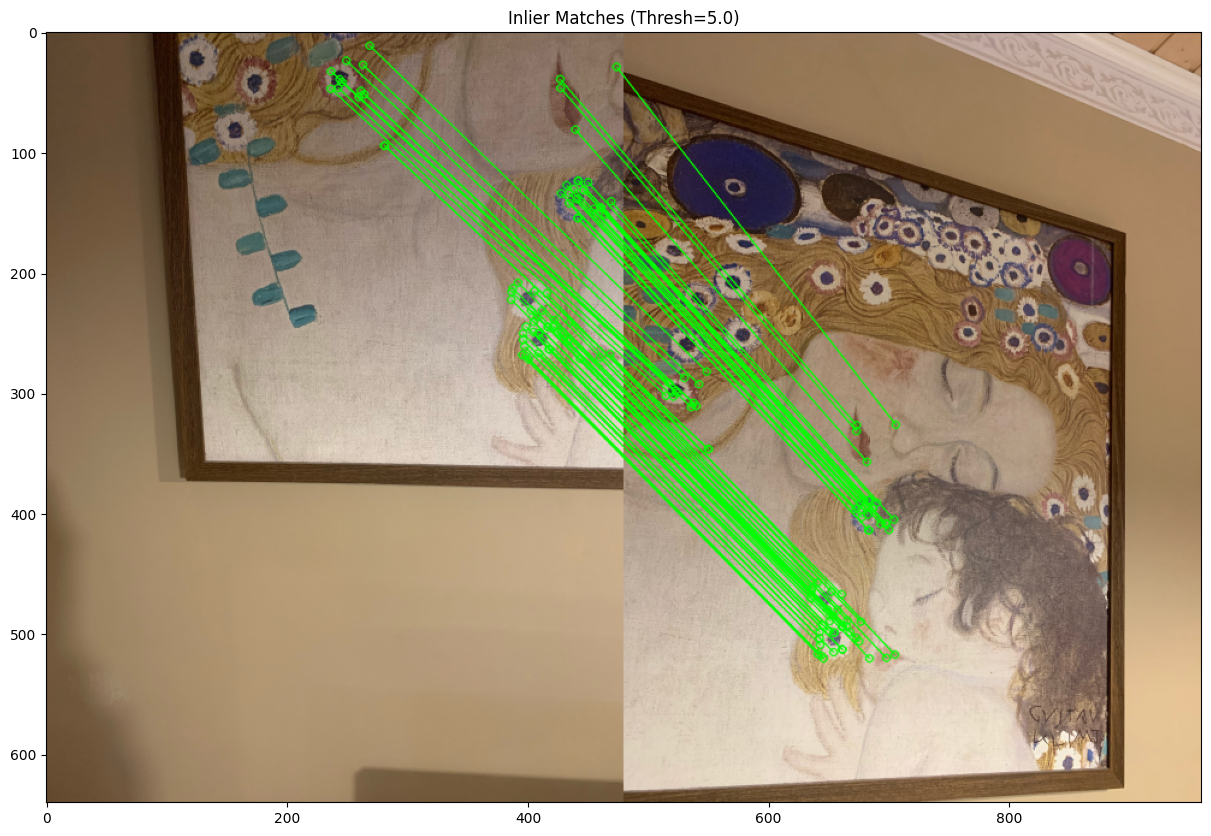

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt

# Load Images
img1 = cv.imread('resources/left.png') # Query (ref)
img2 = cv.imread('resources/right.png') # Train (rot)

if img1 is None or img2 is None:
    print("Error: Images not found! Please upload 'left.png' and 'right.png'.")
else:
    # Convert to RGB for display
    img1_rgb = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
    img2_rgb = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

    # 1. SIFT Detector
    sift = cv.SIFT_create()

    # 2. Keypoints & Descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # 3. Matching (BFMatcher)
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Lowe's Ratio Test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # 4. RANSAC for Homography
    # Need at least 4 matches
    if len(good_matches) > 4:
        # Extract points
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Tune RANSAC threshold (e.g., 5.0)
        ransac_threshold = 5.0 
        H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, ransac_threshold)
        
        # Select inliers
        matches_mask = mask.ravel().tolist()
        inlier_matches = [m for i, m in enumerate(good_matches) if matches_mask[i]]

        print(f"RANSAC Threshold: {ransac_threshold}")
        print(f"Original Matches: {len(good_matches)}")
        print(f"Inlier Matches: {len(inlier_matches)}")

        # Draw Inliers
        draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matches_mask, flags=2)
        img_matches = cv.drawMatches(img1_rgb, kp1, img2_rgb, kp2, good_matches, None, **draw_params)
        
        plt.figure(figsize=(15,10))
        plt.imshow(img_matches)
        plt.title(f"Inlier Matches (Thresh={ransac_threshold})")
        plt.show()
    else:
        print("Not enough matches found.")


### 5) Image Warping
**Task:** Warp `img1` to coordinates of `img2`. 
*Note:* `cv.findHomography(src, dst)` computes mapping from src to dst. If we want to align `img1` (left) onto `img2` (right) or vice versa, we must be careful with source/destination points. 
Usually we warp the 'right' image to the 'left' image (ref). 
Let's assume we align `img2` (right) -> `img1` (left). 
Code below re-computes H for `img2 -> img1` mapping.


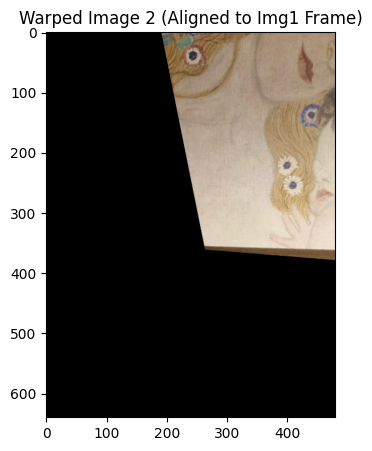

In [6]:
# Setup for warping img2 (right) matching img1 (left)
# src: img2 (right), dst: img1 (left)
if len(good_matches) > 4:
    # Notice the order swap for src/dst to warp img2 -> img1
    src_pts_img2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts_img1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv.findHomography(src_pts_img2, dst_pts_img1, cv.RANSAC, 5.0)

    h1, w1 = img1.shape[:2]
    # Warp img2 using H
    warped_img2 = cv.warpPerspective(img2, H, (w1, h1))

    plt.figure(figsize=(10,5))
    plt.imshow(cv.cvtColor(warped_img2, cv.COLOR_BGR2RGB))
    plt.title("Warped Image 2 (Aligned to Img1 Frame)")
    plt.show()


### 6) Simple Overlay
**Task:** Visually check alignment using `cv.addWeighted`.


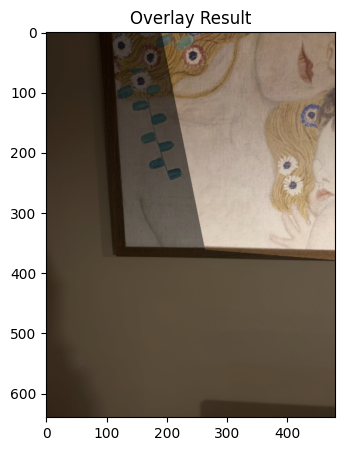

In [7]:
# Overlay
overlay = cv.addWeighted(img1, 0.5, warped_img2, 0.5, 0)

plt.figure(figsize=(10,5))
plt.imshow(cv.cvtColor(overlay, cv.COLOR_BGR2RGB))
plt.title("Overlay Result")
plt.show()

# Q: What does cv.addWeighted do?
# A: It calculates weighted sum: dst = src1*alpha + src2*beta + gamma
# Here it blends 50% of img1 and 50% of warped_img2.


### 7) (Optional) Full Panorama Stitching
**Task:** Create a canvas large enough for both images.


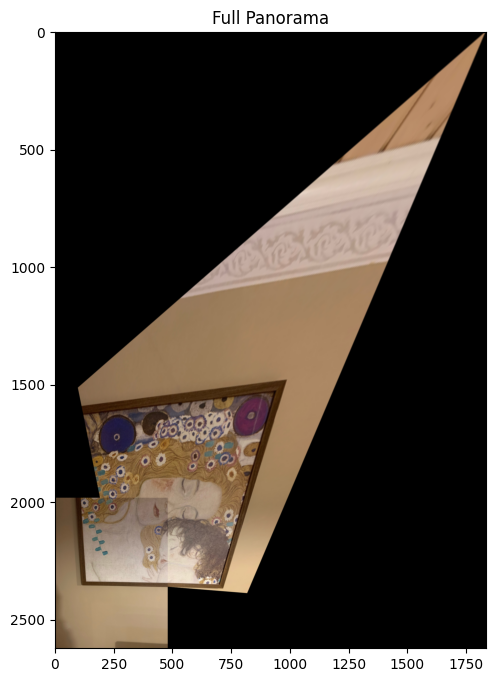

In [8]:
# Calculate size of the Stitching canvas
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

# Get corners of img2
pts_img2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1,1,2)

# Transform corners to img1 coordinate space
pts_img2_transformed = cv.perspectiveTransform(pts_img2, H)

# Concatenate with img1 corners to find bounding box
pts_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
all_points = np.concatenate((pts_img1, pts_img2_transformed), axis=0)

# Find min/max x, y
[xmin, ymin] = np.int32(all_points.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(all_points.max(axis=0).ravel() + 0.5)

# Calculate translation matrix H_translation to shift everything to positive coordinates
translation_dist = [-xmin, -ymin]
H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0,0,1]])

# Full Homography
H_full = H_translation @ H

# Size of new canvas
canvas_w = xmax - xmin
canvas_h = ymax - ymin

# Warp img2 to new canvas
warped_img2_full = cv.warpPerspective(img2, H_full, (canvas_w, canvas_h))

# Paste img1 onto new canvas (taking translation into account)
# img1 is identity transformed, just translated
# We can use warped_img2_full as base and just overwrite the img1 region?
# No, we should blend or overwrite gracefully.
# Simplest: copy img1 into the translated position
y_start, x_start = translation_dist[1], translation_dist[0]
warped_img2_full[y_start:y_start+h1, x_start:x_start+w1] = img1

plt.figure(figsize=(15,8))
plt.imshow(cv.cvtColor(warped_img2_full, cv.COLOR_BGR2RGB))
plt.title("Full Panorama")
plt.show()


In [9]:
# --- Geometric verification using RANSAC ---
if len(good_matches) >= 4:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    ransac_thresh = 1.0
    H, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC, ransac_thresh)
    matches_mask = mask.ravel().tolist()

    inlier_matches = [m for i, m in enumerate(good_matches) if matches_mask[i]]
    print(f"Inliers after RANSAC: {len(inlier_matches)}")

else:
    print("Not enough matches for RANSAC.")
    inlier_matches = good_matches
    matches_mask = None
# --- Geometric verification using RANSAC ---

Inliers after RANSAC: 69
